In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
# read defect prediction data

cm1 = pd.read_csv('datasets/cm1.csv')
jm1 = pd.read_csv('datasets/jm1.csv')
kc1 = pd.read_csv('datasets/kc1.csv')
kc2 = pd.read_csv('datasets/kc2.csv')
pc1 = pd.read_csv('datasets/pc1.csv')

cm1.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,2,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,3,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,4,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,5,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False


In [3]:
# split the dataframe into train, validation, and test

cm1_train, cm1_test = train_test_split(cm1, test_size=0.2)
cm1_train, cm1_val = train_test_split(cm1_train, test_size=0.2)
print(len(cm1_train), 'train examples')
print(len(cm1_val), 'validation examples')
print(len(cm1_test), 'test examples')

318 train examples
80 validation examples
100 test examples


In [4]:
# Create an input pipeline using tf.data

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe.columns=['id', 'loc', 'v1', 'ev', 'iv', 'n', 'v2', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects']
  dataframe = dataframe.drop(['id'], axis=1)
  labels = dataframe.pop('defects')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [5]:
batch_size = 5 # A small batch sized is used for demonstration purposes
cm1_train_ds = df_to_dataset(cm1_train, batch_size=batch_size)
cm1_val_ds = df_to_dataset(cm1_val, shuffle=False, batch_size=batch_size)
cm1_test_ds = df_to_dataset(cm1_test, shuffle=False, batch_size=batch_size)

In [6]:
# Understand the input pipeline

for feature_batch, label_batch in cm1_train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of locs:', feature_batch['loc'])
  print('A batch of targets:', label_batch )

Every feature: ['loc', 'v1', 'ev', 'iv', 'n', 'v2', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
A batch of locs: tf.Tensor([ 3. 11. 21. 18. 16.], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([False False False False False], shape=(5,), dtype=bool)


In [7]:
feature_columns = []

# numeric cols
for header in ['loc', 'v1', 'ev', 'iv', 'n', 'v2', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']:
  feature_columns.append(feature_column.numeric_column(header))

In [8]:
# Create a feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [9]:
batch_size = 32
cm1_train_ds = df_to_dataset(cm1_train, batch_size=batch_size)
cm1_val_ds = df_to_dataset(cm1_val, shuffle=False, batch_size=batch_size)
cm1_test_ds = df_to_dataset(cm1_test, shuffle=False, batch_size=batch_size)

In [10]:
# Create, compile, and train the model

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(cm1_train_ds,
          validation_data=cm1_val_ds,
          epochs=50)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/50
10/10 [==============================] - 2s 160ms/step - loss: 419.5056 - accuracy: 0.7799 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 145.5908 - accuracy: 0.8050 - val_loss: 46.6390 - val_accuracy: 0.8625
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 106.2194 - accuracy: 0.8459 - val_loss: 238.3243 - val_accuracy: 0.8625
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - los

In [11]:
# evaluate accuracy

loss, accuracy = model.evaluate(cm1_test_ds)
print("Accuracy: ", accuracy)

4/4 [==============================] - 0s 5ms/step - loss: 165.5931 - accuracy: 0.8500
Accuracy:  0.85


In [12]:
predictions = model.predict(cm1_test_ds)

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

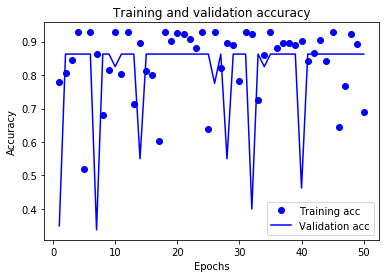

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()